In this notebook we will use the nn class **Sequential** to model a CNN

We will use the single target network

# Import

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from tqdm import tqdm

In [2]:
import load_script

In [3]:
%load_ext autoreload
%autoreload 2

# Loading the dataset

In [4]:
train_dataset,target=load_script.load_dataset(train=True)

In [5]:
test_dataset,test_target=load_script.load_dataset(train=False)

In [6]:
target=target.long()
test_target=test_target.long()

# Added modules

In [7]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [8]:
class Tensor4D(nn.Module):
    def forward(self,input):
        return input.view(input.shape[0],1,*input.shape[1:])

In [9]:
class Tensor3D(nn.Module):
    def forward(self,input):
        return input.view(input.shape[0],input.shape[1],-1)

# Normalization

In [10]:
train_dataset.mean(0)

Variable containing:
 7.3101e+01  7.3109e+01  7.2001e+01  ...   6.4324e+01  6.5037e+01  6.5048e+01
 5.0706e+00  5.9728e+00  4.1829e+00  ...  -3.1212e+00 -2.7500e+00 -2.3117e+00
 5.3022e+01  5.3706e+01  5.2293e+01  ...   4.5319e+01  4.5553e+01  4.6292e+01
                ...                   ⋱                   ...                
 1.3597e+01  1.3734e+01  1.3298e+01  ...   1.0306e+01  1.0556e+01  1.0504e+01
 2.3973e+01  2.3983e+01  2.2980e+01  ...   2.2531e+01  2.2226e+01  2.2265e+01
 9.5851e+00  9.5892e+00  8.4953e+00  ...   8.9079e+00  9.0392e+00  8.8203e+00
[torch.FloatTensor of size 28x50]

In [11]:
train_dataset.shape

torch.Size([316, 28, 50])

In [12]:
mean=train_dataset.mean(0).view(1,28,-1)
std=train_dataset.std(0).view(1,28,-1)

In [13]:
train_dataset=(train_dataset-mean)/std
test_dataset=(test_dataset-mean)/std

# Defining the network

### Simple Network

In [14]:
class MyConv1D:
    def __init__(self,input_channels,output_channels,kernel,dropout_rate=0.8,batch_norm=True):
        self.conv=nn.Conv1d(input_channels,output_channels,kernel)
        self.relu=nn.ReLU()
        self.batch_norm=nn.BatchNorm1d(output_channels)
        self.dropout=nn.Dropout(dropout_rate)
        if batch_norm:
            self._layers=[self.conv,self.relu,self.batch_norm,self.dropout]
        else:
            self._layers=[self.conv,self.relu,self.batch_norm,self.dropout]
    
    @property
    def layers(self):
        return self._layers

In [15]:
class ThreeLayersParams(nn.Module):
    
    num_my_conv_layers=3
    num_linear_layers=2
    
    def __init__(self,params):
        super(ThreeLayersParams,self).__init__()
        
        self.params=params
        
        layers=[]
        for i in range(self.num_my_conv_layers): 
            layers+=MyConv1D(*self.params[i]).layers
        
        layers.append(Flatten())
        a=[*self.params[self.num_my_conv_layers]]
        layers.append(nn.Linear(*self.params[self.num_my_conv_layers]))
        layers.append(nn.ReLU())
        
        layers.append(nn.Linear(*self.params[self.num_my_conv_layers+1]))
        
        self.sequential=nn.Sequential(*layers)
        
    def forward(self,x):
        x=self.sequential(x)
        
        return x

# Training

In [16]:
class LayerParams:
    def __init__(self,*args):
        self._params=[*args]
        
    def __str__(self):
        return str(self._params)
    
    def __repr__(self):
        return str(self)
    
    def __getitem__(self,key):
        return self._params[key]

In [17]:
class LayersParams:
    
    def __init__(self,*args):
        self.params=[*args]
        
    def __getitem__(self,key):
        return self.params[key]

In [18]:
class TrainParams:
    def __init__(self,mini_batch_size=79,
                 max_epoch=1000,
                 weights_initialization=0.02,
                 randomize_training_dataset=True):
        self._mini_batch_size=mini_batch_size
        self._max_epoch=max_epoch
        self._weights_initialization=weights_initialization
        self._randomize_training_dataset=randomize_training_dataset
        
    def params(self):
        return [self._mini_batch_size,self._max_epoch,self._max_epoch,self._randomize_training_dataset]
    
    @property
    def mini_batch_size(self):
        return self._mini_batch_size
    @property
    def max_epoch(self):
        return self._max_epoch
    @property
    def weights_initialization(self):
        return self._weights_initialization
    @property
    def randomize_training_dataset(self):
        return self._randomize_training_dataset

In [19]:
class NetworkParams:
    def __init__(self,conv_filters=False,conv_kernels=3,dropout_rate=0.8,batch_norm=True,linear_filters=False):
        self._conv_filters=conv_filters
        self._conv_kernels=conv_kernels
        self._dropout_rate=dropout_rate
        self._batch_norm=batch_norm
        self._linear_filters=linear_filters
        
    def params(self):
        return [self._conv_filters,self._conv_kernels,self._dropout_rate,self._batch_norm,self._linear_filters]

In [31]:
class OptimizerParams:
    def __init__(self,learning_rate=0.001,
                 weight_decay=0):
        self._learning_rate=learning_rate
        self._weight_decay=weight_decay
        
    def params(self):
        return {'lr':self._learning_rate,'weight_decay':self._weight_decay}
    
    @property
    def learning_rate(self):
        return self._learning_rate
    @property
    def weight_decay(self):
        return self._weight_decay

In [32]:
class Params:
    ''' Class that defines the parameters of a network evaluation.
    
    
    '''
    
    _input_shape=(28,50)
    
    def __init__(self,network_type,
                 optimizer_type,
                 criterion_type,
                 network_params=NetworkParams(),
                 optimizer_params=OptimizerParams(),
                 train_params=TrainParams(),
                 plot=True,
                 verbose=False):
        
        # Set up network
        self._network_type=network_type
        self._network_params=network_params
        self._layers_params=self.set_up_network_params(*self.network_params.params())        
        self._network=network_type(self._layers_params)

        # Set up optimizer
        self._optimizer_params=optimizer_params
        self._optimizer=optimizer_type(self.network.parameters(), **self.optimizer_params.params())

        # Set up criterion
        self._criterion=criterion_type()
        
        # Set up training parameters
        self._train_params=train_params
        
        # Set up visualization parameters
        self._plot=plot
        self._verbose=verbose
        
    def set_up_network_params(self,conv_filters,conv_kernels,dropout_rate,batch_norm,linear_filters):
        # We automatically create LayersParams based on the input given
        self._num_my_conv_layers=self._network_type.num_my_conv_layers
        self._num_linear_layers=self._network_type.num_linear_layers
        
        # Set up conv_filters
        self._conv_filters=[self._input_shape[0]]+\
                    self.add_params_sequence(self._num_my_conv_layers,conv_filters,self._input_shape[0])
        
        # Set up conv_kernel
        self._conv_kernels=self.add_params_sequence(self._num_my_conv_layers,conv_kernels,3)
        
        # Set up dropout
        self._dropout_rate=self.add_params_sequence(self._num_my_conv_layers,dropout_rate,0.2)
        
        # Set up batch norm
        self._batch_norm=self.add_params_sequence(self._num_my_conv_layers,batch_norm,True)
        
        
        # Set up linar_layers
        self._linear_layer_start_filters=int(self._conv_filters[-1]*(self._input_shape[1]-
                                        np.sum([(x-1) for x in self._conv_kernels])))
        print(self._conv_filters[-1])
        self._linear_filters=[self._linear_layer_start_filters]+\
                        self.add_params_sequence(self._num_linear_layers,linear_filters,False)
        
        self._layer_params_list=[]
        for i in range(self._num_my_conv_layers):
            self._layer_params_list.append(LayerParams(*self._conv_filters[i:i+2],self._conv_kernels[i],self._dropout_rate[i]))
        for i in range(self._num_linear_layers):
            self._layer_params_list.append(LayerParams(*self._linear_filters[i:i+2]))
        
        _layer_params=LayerParams(*self._layer_params_list)
        return _layer_params
        
    def add_params_sequence(self,num_layers,params,default_value):
        if not params:
            params=[default_value]*num_layers
        try:
            if len(params)!=num_layers:
                params=[default_value]*num_layers
        except:
            params=[params]*num_layers
            
        return params
    
    
    @property
    def network(self):
        return self._network
    @property
    def optimizer(self):
        return self._optimizer
    @property
    def criterion(self):
        return self._criterion
    @property
    def network_params(self):
        return self._network_params
    @property
    def optimizer_params(self):
        return self._optimizer_params
    @property
    def train_params(self):
        return self._train_params
    @property
    def plot(self):
        return self._plot
    @property
    def verbose(self):
        return self._verbose

In [33]:
class Train:
    
    def __init__(self):
        pass
        
    def __call__(self,params,repetitions=5):
        epochs=[]
        errors_max=[]
        errors_mean=[]
        for i in range(repetitions):
            for param in params.network.parameters():
                param.data.normal_(0, params.train_params.weights_initialization)
            print('Repetition',i)
            epoch,error_max,error_mean=self.train_test_network(params)
            epochs.append(epoch)
            errors_max.append(error_max)
            errors_mean.append(error_mean)
        
        return epochs,errors_max,errors_mean
    
    
    def train_test_network(self,params):
    
        errors_train=[]
        errors_test=[]
        
        
        for epoch in tqdm(range(params.train_params.max_epoch)):
            
            total_loss,output_train,error_train=self.train_epoch(params)
            output_test,error_test=self.test_epoch(params)
        
        
            errors_train.append(error_train)
            errors_test.append(error_test)
            
            if epoch%10==0 and params.verbose:
                print('Epoch:',epoch,'Loss:',total_loss,'Correct:',str(error_train*100)[:5]+"%",
                     'Correct test:',str(error_test*100)[:5]+"%")
                
        if params.plot:
            
            print('Performance:',np.mean(errors_test[300:]))
            plt.plot(list(range(epoch+1)),errors_train,label='Errors train')
            plt.plot(list(range(epoch+1)) ,errors_test,label='Errors test')
            
            plt.legend()
            plt.show()
                 
        return epoch,np.max(errors_test),np.mean(errors_test[300:])
    
    
    
    def train_epoch(self,params):
        
        # Set training True
        params.network.train(True)
        
        # Randomize training dataset
        if params.train_params.randomize_training_dataset:
            random_permutation=torch.randperm(train_dataset.shape[0])
        else:
            random_permutation=torch.arange(train_dataset.shape[0])

        train_dataset_shuffled=train_dataset[random_permutation]
        target_shuffled=target[random_permutation]
        
        
        # Iterate on the dataset
        total_loss=0
        output_target=torch.zeros(target_shuffled.shape[0])
        for b in range(0,train_dataset_shuffled.shape[0],params.train_params.mini_batch_size):

            train_element=train_dataset_shuffled.narrow(0,b,params.train_params.mini_batch_size)
            target_element=target_shuffled.narrow(0,b,params.train_params.mini_batch_size)

            params.optimizer.zero_grad()

            out=params.network(train_element)
            output_target[b:b+params.train_params.mini_batch_size]=(out[:,1]>out[:,0]).data

            loss=params.criterion(out,target_element)
            loss.backward()
            params.optimizer.step()
            total_loss+=loss.data[0]
            
        error_train=np.sum(list(output_target.long()==target_shuffled.data))/target.shape[0]    
        
        return total_loss,output_target,error_train
    
    def test_epoch(self,params):
        params.network.train(False)
        output_test=torch.zeros(test_target.shape[0])
        out=params.network.forward(test_dataset)
        output_test=(out[:,1]>out[:,0]).data.long()
        error_test=np.sum(list(output_test==test_target.data))/test_target.shape[0]
        
        return output_test,error_test

  0%|          | 1/400 [00:00<00:55,  7.15it/s]

28
Repetition 0


100%|██████████| 400/400 [00:39<00:00, 10.10it/s]


Performance: 0.783


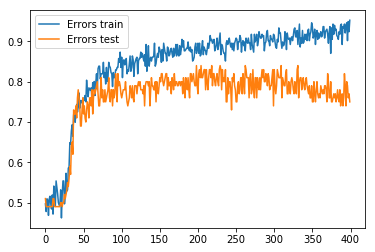

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 1


100%|██████████| 400/400 [00:40<00:00,  9.95it/s]


Performance: 0.7994


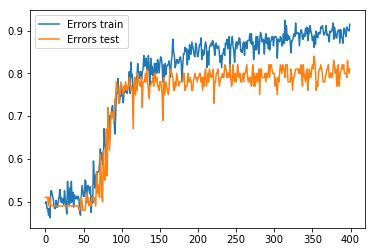

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 2


100%|██████████| 400/400 [00:39<00:00, 10.03it/s]


Performance: 0.8099


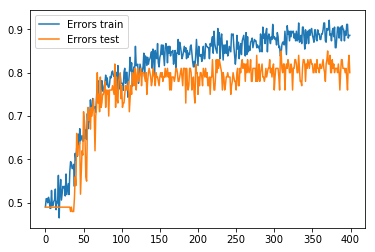

  0%|          | 0/400 [00:00<?, ?it/s]

Repetition 3


  4%|▍         | 16/400 [00:02<00:51,  7.51it/s]

In [ ]:
net_type=ThreeLayersParams
optimizer_type=optim.Adam
criterion_type=nn.CrossEntropyLoss
network_params=NetworkParams(linear_filters=[200,2])
optimizer_params=OptimizerParams()
train_params=TrainParams(max_epoch=400)


params=Params(net_type,optimizer_type,criterion_type,network_params=network_params,
              optimizer_params=optimizer_params,train_params=train_params,)

train=Train()
train(params)